Many members of our community focus on developing numerical models to study how landscapes evolve over time. The simplest and most commonly used transport law used to capture the evolution of hillslopes is a diffusion equation:

$$\frac{\partial z}{\partial t} = K \; \frac{\partial^2 z}{\partial x^2}$$

where $z$ is elevation, $x$ is the horizontal distance, and $K$ is a landscape diffusion coefficient.

## Finite difference methods

We can solve partial differential equations using finite difference methods by replacing the spatial and time derivatives with approximations that use the gridded data. $xx$ is the index along an array of x positions and $tt$ is the timestep.

The time derivative $\partial z/\partial t$ can be approximated using a forward difference:

$$\frac{\partial z}{\partial t} \approx \frac{z_{xx, \; tt+1} - z_{xx, \; tt}}{d t}$$

The second spatial derivative $\frac{\partial^2 z}{\partial x^2}$ can be approximated by combining a forward and a backwards difference:

$$\frac{\partial^2 z}{\partial x^2} \approx \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

The diffusion equation can then be rewritten as:

$$\frac{z_{xx, \; tt+1} - z_{xx, \; tt}}{d t} = K \;  \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

We can rearrange this equation to solve for the elevation $z$ at position $x$ at timestep $t+1$:

$$z_{xx, \; tt+1} = z_{xx, \; tt} + K \; d t \; \frac{z_{xx+1, \; tt} - 2 z_{xx, \; tt} + z_{xx-1, \; tt}}{(d x)^2}$$

Essentially, the elevation of a point at any timestep depends on the elevation of that point and its two neighbors at the previous timestep

[[[[[[[[[[[[[[[[[[[[add fig here]]]]]]]]]]]]]]]]]]]]]

## Diffusion in 1D

Let's start by simulating the evolution of a 1D profile across our dataset due to diffusion. First, we need to extract a profile across the DEM:

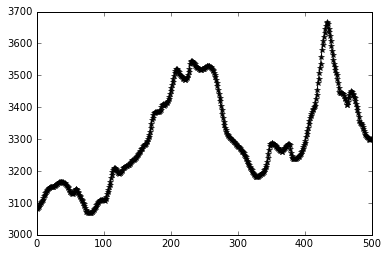

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

topo = np.loadtxt('data/topo.asc', delimiter=',')

profile = topo[:,120]

plt.plot(profile, 'k*-')

This is the topography at time $t = 0$. For every point in the array, the topography at time $t = dt$ is going to be given by the equation above.

Let's create a new NumPy array of the same shape as the profile where we can store the values of the new elevation values. The NumPy function `zeros_like()` creates an array of the same shape where every entry is zero:





Let's now model the evolution of this profile due to diffusion.




We will follow this algorithm:

* loop through time ($\; d t \;$)
    * step through the profile ($\; d x \;$)
        * calculate $z_{x, \; t+1}$
        
At every timestep, we will use the elevations at time $t$ to calculate the elevations at time $t+1$. We need to create a new array of the same size as the old profile to store the values of the new profile. We will also create a new variable to keep track of the old profile. Because NumPy arrays are mutable objects, we need to make a copy of the profile object.

In [5]:
newProfile = np.zeros_like(profile)

print profile.shape, newProfile.shape
print profile.max(), newProfile.max()

(500,) (500,)
3668.7078 0.0


The new value of any one point using the finite difference diffusion equation depends on the values of that point and its two neighbors, so we have to decide what to do about the first and last cells in the profile, since they only have one neighbor. The simplest solution is to keep their elevation fixed and not let them evolve:

In [6]:
newProfile[0] = profile[0]
newProfile[-1] = profile[-1]

We can now use the finite difference diffusion equation to calculate the elevation of the interior cells of the profile after one timestep.

For the cell with index 1, we can write the equation as:

In [10]:
K = 1
dt = 1
dx = 2 #meters

newProfile[1] = profile[1] + K * dt * (profile[2] - 2 * profile[1] + profile[0]) / dx**2

print profile[1]
print newProfile[1]

3082.6816
3082.8401


We chose dummy values for $K$ and $dt$. The value of $dx$ is the cell spacing in the original topo raster.

The equation for the elevation of the cell with index 2 is very similar:

In [12]:
newProfile[2] = profile[2] + K * dt * (profile[3] - 2 * profile[2] + profile[1]) / dx**2

print profile[1], profile[2]
print newProfile[1], newProfile[2]

3082.6816 3085.4751
3082.8401 3085.8378


We could keep doing this for every single cell in the array, but it would get boring very quickly! The code would also not scale very well, since we wouldn't be able to use it for longer or shorter profiles. It would also be very fragile, since it's likely that we would accidentally introduce an error into the code by mistyping something.

Automating repetitive tasks is best accomplished with a loop. A For Loop repeats a set of actions for every item in a collection (every letter in a word, every number in some range, every name in a list) until it runs out of items:

In [13]:
word = 'lead'
for char in word:
    print char

l
e
a
d


This is shorter than writing individual statements for printing every letter in the word and it easy scales to longer or shorter words:

In [16]:
word = 'aluminium'
for char in word:
    print char

a
l
u
m
i
n
i
u
m


In [15]:
word = 'tin'
for char in word:
    print char

t
i
n


The general form of a for loop is:

In [ ]:
for item in collection:
    do things with item

A for loop starts with the word "for", then the variable name that each item in the collection is going to take inside the loop, then the word "in", and then the collection or sequence of items to loop through.

In Python, there must be a colon at the end of the line starting the loop. The commands that are run repeatedly inside the loop are indented below that. Unlike many other languages, there is no command to end a loop (e.g. `end for`): the loop ends once the indentation moves back.

In [17]:
length = 0
word = 'elephant'
for letter in word:
    length = length + 1
print 'There are', length, 'letters in', word

There are 8 letters in elephant


It’s worth tracing the execution of this little program step by step. Since there are eight characters in ‘elephant’, the statement inside the loop will be executed eight times. The first time around, `length` is zero (the value assigned to it on line 1) and `letter` is "e". The code adds 1 to the old value of `length`, producing 1, and updates `length` to refer to that new value. The next time the loop starts, `letter` is "l" and `length` is 1, so `length` is updated to 2. Once there are no characters left in "elephant" for Python to assign to `letter`, the loop finishes and the `print` statement tells us the final value of length.

Note that a loop variable is just a variable that’s being used to record progress in a loop. It still exists after the loop is over (and has the last value it had inside the loop). We can re-use variables previously defined as loop variables, overwriting their value:

In [19]:
letter = 'z'
for letter in 'abc':
    print letter
print 'after the loop, letter is', letter

a
b
c
after the loop, letter is c


# add callout and exercises from 03-loops